In [1]:
import numpy as np
import pandas as pd
import spacy
import pickle
from matplotlib import pyplot as plt
from scipy import spatial

from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer

from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import jaccard_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
df = pd.read_csv("./output/queries_df.csv")
df.head()

,QUERY,REMEMBERING,UNDERSTANDING,APPLYING,ANALYZING,EVALUATING,CREATING
0,"""their own language"" means _ .",1.0,0.0,0.0,0.0,0.0,0.0
1,"""you may think the popular singer jay chow is ...",0.0,1.0,0.0,0.0,0.0,0.0
2,". at midnight, nasreddin saw _ in his garden.",1.0,0.0,0.0,0.0,0.0,0.0
3,. david beckham is _ years old.,1.0,0.0,0.0,0.0,0.0,0.0
4,. david beckham's family name is _ and zhou...,1.0,0.0,0.0,0.0,0.0,0.0


In [3]:
categories = ["REMEMBERING", "UNDERSTANDING", "APPLYING", "ANALYZING", "EVALUATING", "CREATING"]

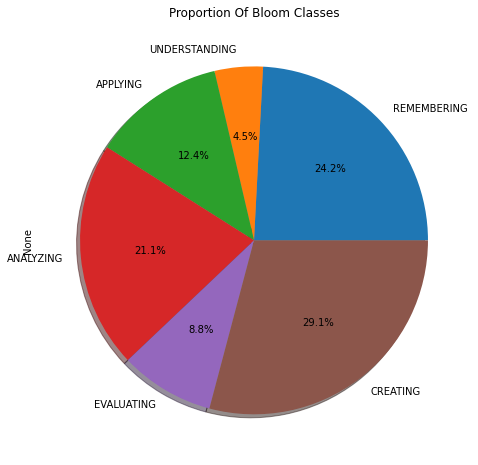

In [4]:
df[categories].sum().plot.pie(figsize=(8, 8), title="Proportion Of Bloom Classes", legend=False, \
                   autopct='%1.1f%%', \
                   shadow=True, startangle=0)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df["QUERY"], df[categories], test_size=0.25, random_state=41)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=41)

In [6]:
proportion_data = pd.DataFrame([X_train.shape[0], X_valid.shape[0], X_test.shape[0]], columns=["Counts"], index=["Train", "Valid", "Test"])
proportion_data

,Counts
Train,120996
Valid,21353
Test,47450


In [7]:
import helper
import models
import metrics

In [8]:
def join_process(text):
    return " ".join(helper.process_text(text))

In [9]:
X_valid_transform = X_valid.apply(join_process)
X_valid_transform.head()

133312    book say coeffici static friction equal forc f...
137719                               345 pi mean 345 x 3.14
16430     forc appli constantli static friction affect o...
109978                              exactli adjac angl mean
48047                              what 360 degre angl call
Name: QUERY, dtype: object

In [10]:
X_train_transform = X_train.apply(join_process)
X_test_transform = X_test.apply(join_process)

In [11]:
X_train_transform.sample(5)

159240                    rotat protractor tri measur degre
168097                 call autosom cell diploid haploid g1
95894     pure whole thing random collid one anoth resul...
73680                                electron alpha particl
167060                                   number line extend
Name: QUERY, dtype: object

In [12]:
vect = TfidfVectorizer(max_features=1500)

In [13]:
X_train_vect = vect.fit_transform(X_train_transform)
X_valid_vect = vect.transform(X_valid_transform)
X_test_vect = vect.transform(X_test_transform)

In [14]:
X_train_vect.shape

(120996, 1500)

In [15]:
labels = np.array(range(0, 6))
len(labels)

6

In [16]:
y_train.head()

,REMEMBERING,UNDERSTANDING,APPLYING,ANALYZING,EVALUATING,CREATING
71543,0.0,0.0,0.0,1.0,0.0,0.0
155386,1.0,0.0,0.0,0.0,0.0,0.0
75048,0.0,0.0,1.0,0.0,0.0,0.0
130361,0.0,0.0,0.0,1.0,0.0,0.0
171257,0.0,0.0,0.0,1.0,0.0,0.0


In [17]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_jobs=-1, random_state=27, verbose=1, class_weight="balanced")

In [18]:
clf = clf.fit(X_train_vect, y_train.values)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.8s finished


In [27]:
valid_pred_prob = np.array(clf.predict_proba(X_valid_vect))[:, :, 1].T

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.5s finished


In [28]:
performances = metrics.get_performance_metrics(y_valid.values, valid_pred_prob, categories)
performances

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,1543,15204,1040,3566,0.784,0.239,0.302,0.936,0.597,0.81,0.76,0.401,0.5
UNDERSTANDING,151,20225,193,784,0.954,0.044,0.161,0.991,0.439,0.963,0.762,0.236,0.5
APPLYING,630,18247,486,1990,0.884,0.123,0.24,0.974,0.565,0.902,0.799,0.337,0.5
ANALYZING,1499,15938,843,3073,0.817,0.214,0.328,0.95,0.64,0.838,0.757,0.434,0.5
EVALUATING,395,19161,329,1468,0.916,0.087,0.212,0.983,0.546,0.929,0.799,0.305,0.5
CREATING,1899,13785,1314,4355,0.735,0.293,0.304,0.913,0.591,0.76,0.719,0.401,0.5


In [29]:
from sklearn.metrics import classification_report, confusion_matrix

In [34]:
print(classification_report(np.dot(y_valid.values, labels), np.argmax(valid_pred_prob, axis=1), target_names=categories))

               precision    recall  f1-score   support

  REMEMBERING       0.49      0.50      0.49      5109
UNDERSTANDING       0.36      0.28      0.31       935
     APPLYING       0.46      0.42      0.44      2620
    ANALYZING       0.52      0.47      0.49      4572
   EVALUATING       0.42      0.36      0.39      1863
     CREATING       0.47      0.56      0.51      6254

     accuracy                           0.48     21353
    macro avg       0.45      0.43      0.44     21353
 weighted avg       0.48      0.48      0.48     21353



In [37]:
print(classification_report(y_valid.values>0.5, valid_pred_prob>0.5, target_names=categories))

               precision    recall  f1-score   support

  REMEMBERING       0.60      0.30      0.40      5109
UNDERSTANDING       0.44      0.16      0.24       935
     APPLYING       0.56      0.24      0.34      2620
    ANALYZING       0.64      0.33      0.43      4572
   EVALUATING       0.55      0.21      0.31      1863
     CREATING       0.59      0.30      0.40      6254

    micro avg       0.59      0.29      0.39     21353
    macro avg       0.56      0.26      0.35     21353
 weighted avg       0.59      0.29      0.38     21353
  samples avg       0.29      0.29      0.29     21353



In [42]:
from sklearn.model_selection import GridSearchCV
params = {
    'n_estimators'      : range(100,500,50),
    'max_depth'         : [8, 9, 10, 11, 12],
    'max_features': ['auto'],
    'criterion' :['gini']
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch1 = GridSearchCV(estimator = clf, param_grid = params, n_jobs=-1,verbose = 10, cv=5)

In [43]:
gsearch1 = gsearch1.fit(X_train_vect, y_train.values)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 158 out of 200 | elapsed:  7.2min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done 179 out of 200 | elapsed:  8.1min remaining:   56.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  8.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  8.9min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBacke

In [44]:
gsearch1.best_score_

8.264462809917356e-06

In [45]:
gsearch1.best_params_

{'criterion': 'gini',
 'max_depth': 11,
 'max_features': 'auto',
 'n_estimators': 100}

In [51]:
valid_pred_prob = np.array(clf.predict_proba(X_valid_vect))[:, :, 1].T

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.5s finished


In [52]:
performances = metrics.get_performance_metrics(y_valid.values, valid_pred_prob, categories)
performances

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,1543,15204,1040,3566,0.784,0.239,0.302,0.936,0.597,0.81,0.76,0.401,0.5
UNDERSTANDING,151,20225,193,784,0.954,0.044,0.161,0.991,0.439,0.963,0.762,0.236,0.5
APPLYING,630,18247,486,1990,0.884,0.123,0.24,0.974,0.565,0.902,0.799,0.337,0.5
ANALYZING,1499,15938,843,3073,0.817,0.214,0.328,0.95,0.64,0.838,0.757,0.434,0.5
EVALUATING,395,19161,329,1468,0.916,0.087,0.212,0.983,0.546,0.929,0.799,0.305,0.5
CREATING,1899,13785,1314,4355,0.735,0.293,0.304,0.913,0.591,0.76,0.719,0.401,0.5


In [54]:
print(classification_report(y_valid.values[:, 1]>0.5, valid_pred_prob[:, 1]>0.5))

              precision    recall  f1-score   support

       False       0.96      0.99      0.98     20418
        True       0.44      0.16      0.24       935

    accuracy                           0.95     21353
   macro avg       0.70      0.58      0.61     21353
weighted avg       0.94      0.95      0.94     21353



In [55]:
print(classification_report(np.dot(y_valid.values, labels), np.argmax(valid_pred_prob, axis=1), target_names=categories))

               precision    recall  f1-score   support

  REMEMBERING       0.49      0.50      0.49      5109
UNDERSTANDING       0.36      0.28      0.31       935
     APPLYING       0.46      0.42      0.44      2620
    ANALYZING       0.52      0.47      0.49      4572
   EVALUATING       0.42      0.36      0.39      1863
     CREATING       0.47      0.56      0.51      6254

     accuracy                           0.48     21353
    macro avg       0.45      0.43      0.44     21353
 weighted avg       0.48      0.48      0.48     21353



In [57]:
print(classification_report(y_valid.values>0.5, valid_pred_prob>0.5, target_names=categories))

               precision    recall  f1-score   support

  REMEMBERING       0.60      0.30      0.40      5109
UNDERSTANDING       0.44      0.16      0.24       935
     APPLYING       0.56      0.24      0.34      2620
    ANALYZING       0.64      0.33      0.43      4572
   EVALUATING       0.55      0.21      0.31      1863
     CREATING       0.59      0.30      0.40      6254

    micro avg       0.59      0.29      0.39     21353
    macro avg       0.56      0.26      0.35     21353
 weighted avg       0.59      0.29      0.38     21353
  samples avg       0.29      0.29      0.29     21353



In [28]:
clf2 = gsearch1.best_estimator_

params1 = {
    'n_estimators'      : range(350,450,10),
    'max_depth'         : [11, 12, 13]
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch2 = GridSearchCV(estimator = clf2, param_grid = params1, scoring='f1_macro',n_jobs=-1,verbose = 10, cv=5)
gsearch2.fit(X_train_vect, np.dot(y_train.values, labels))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 103 out of 150 | elapsed:  2.4min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done 119 out of 150 | elapsed:  2.7min remaining:   42.6s
[Parallel(n_jobs=-1)]: Done 135 out of 150 | elapsed:  3.1min remaining:   21.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.3min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:    3.2s finished


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=12, n_estimators=400,
                                              n_jobs=-1, random_state=27,
                                              verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': [11, 12, 13],
                         'n_estimators': range(350, 450, 10)},
             scoring='f1_macro', verbose=10)

In [29]:
gsearch2.best_score_

0.1553922395853586

In [30]:
gsearch2.best_params_

{'max_depth': 13, 'n_estimators': 420}

In [31]:
clf3 = gsearch2.best_estimator_

params2 = {
    'n_estimators'      : range(400,440,5),
    'max_depth'         : [13,14,15]
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch3 = GridSearchCV(estimator = clf3, param_grid = params2, scoring='f1_macro',n_jobs=-1,verbose = 10, cv=5)
gsearch3.fit(X_train_vect, np.dot(y_train.values, labels))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  70 out of 120 | elapsed:  2.3min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  83 out of 120 | elapsed:  2.4min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  96 out of 120 | elapsed:  2.9min remaining:   43.4s
[Parallel(n_jobs=-1)]: Done 109 out of 120 | elapsed:  3.1min remaining:   19.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.2min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 435 out of 435 | elapsed:    3.3s finished


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=13, n_estimators=420,
                                              n_jobs=-1, random_state=27,
                                              verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': [13, 14, 15],
                         'n_estimators': range(400, 440, 5)},
             scoring='f1_macro', verbose=10)

In [34]:
gsearch3.best_score_

0.16349999142505417

In [35]:
gsearch3.best_params_

{'max_depth': 15, 'n_estimators': 435}

In [36]:
clf4 = gsearch3.best_estimator_

params3 = {
    'max_depth': range(14,20,1)
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch4 = GridSearchCV(estimator = clf4, param_grid = params3, scoring='f1_macro', n_jobs=-1,verbose=10, cv=5)
gsearch4.fit(X_train_vect, np.dot(y_train.values, labels))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   56.5s remaining:  8.5min
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:   57.9s remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:   58.9s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   59.2s remaining:   59.2s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   59.7s remaining:   34.6s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  1.0min remaining:   18.3s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.0min remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 435 out of 435 | elapsed:    3.7s finished


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=15, n_estimators=435,
                                              n_jobs=-1, random_state=27,
                                              verbose=1),
             n_jobs=-1, param_grid={'max_depth': range(14, 20)},
             scoring='f1_macro', verbose=10)

In [37]:
gsearch4.best_score_

0.18531384405503276

In [38]:
gsearch4.best_params_

{'max_depth': 19}

In [39]:
clf5 = gsearch4.best_estimator_

params4 = {
    'max_depth': range(19,50,2)
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch5 = GridSearchCV(estimator = clf5, param_grid = params4, scoring='f1_macro',n_jobs=-1,verbose = 10, cv=5)
gsearch5.fit(X_train_vect, np.dot(y_train.values, labels))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  26 out of  80 | elapsed:  2.0min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done  35 out of  80 | elapsed:  4.0min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done  44 out of  80 | elapsed:  4.8min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done  53 out of  80 | elapsed:  5.6min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  62 out of  80 | elapsed:  6.1min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  71 out of  80 | elapsed:  7.5min remaining:   57.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  7.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  7.7min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 435 out of 435 | elapsed:   11.4s finished


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=19, n_estimators=435,
                                              n_jobs=-1, random_state=27,
                                              verbose=1),
             n_jobs=-1, param_grid={'max_depth': range(19, 50, 2)},
             scoring='f1_macro', verbose=10)

In [40]:
gsearch5.best_score_

0.32143182179657337

In [41]:
gsearch5.best_params_

{'max_depth': 49}

In [42]:
final_clf = gsearch5.best_estimator_

In [43]:
final_clf.fit(X_train_vect, np.dot(y_train.values, labels))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 435 out of 435 | elapsed:   11.3s finished


RandomForestClassifier(max_depth=49, n_estimators=435, n_jobs=-1,
                       random_state=27, verbose=1)

In [46]:
valid_pred_prob = final_clf.predict_proba(X_train_vect)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 435 out of 435 | elapsed:    1.1s finished


In [47]:
performances = metrics.get_performance_metrics(y_train.values, valid_pred_prob, categories)
performances

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,760,91835,4,28397,0.765,0.241,0.026,1,0.995,0.764,0.89,0.051,0.5
UNDERSTANDING,2,115549,0,5445,0.955,0.045,0,1,1,0.955,0.956,0.001,0.5
APPLYING,158,106060,0,14778,0.878,0.123,0.011,1,1,0.878,0.921,0.021,0.5
ANALYZING,3512,95308,106,22070,0.817,0.211,0.137,0.999,0.971,0.812,0.901,0.241,0.5
EVALUATING,33,110329,0,10634,0.912,0.088,0.003,1,1,0.912,0.928,0.006,0.5
CREATING,2309,85783,6,32898,0.728,0.291,0.066,1,0.997,0.723,0.861,0.123,0.5
